## Some imports

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta

## Creating Pandas Transapp DataFrames

In [2]:
"""
1. Patente
2. Sonda (servicio interno que identifica recorrido de manera unica) (variantes)
3. Servicio de Usuario (lo que ve el pasajero)
4. Dia y hora (UTC). Ultimo dia de Abril y ultimo día de Mayo
5. Latitud
6. Longitud
7. x (UTM)
8. y (UTM)
9. Distancia en Ruta (desde inicio hasta t)
10. Distancia a la ruta (ortogonal a la polilinea)
11. Velocidad instantanea (maquina del GPS del bus)
12. Operador (codificacion empresa)
13. Identificador de expedición (viaje de un lugar a otro)
"""

def create_gps(gps_name):
    columns = ["Patente", "GPS_COD_SINRUT", "idx_user", "Date", "LAT", "LON", "x_UTM", "y_UTM", "dist_rute", "dist_to_rute", "velocity", "idx_empresa", "idx_expedition"]
    # GPS Data
    df_gps = pd.read_csv(gps_name,header=None,delimiter=";")
    df_gps.columns = columns
    df_gps.index = df_gps["Date"]
    df_gps.index = pd.to_datetime(df_gps.index)
    return df_gps

def create_dict(dict_name):
    # Dictionary Data
    df_dict = pd.read_csv(dict_name,delimiter=";",encoding='latin-1')
    df_dict.index = df_dict["COD_SINRUT"]
    return df_dict

def create_shape(shape_name):
    # Shape Data
    df_shape = pd.read_csv(shape_name,delimiter=";")
    df_shape.index = df_shape["ROUTE_NAME"]
    return df_shape

In [3]:
def extract_bus(bus_name, is_ida, df_dict, df_gps):
    if is_ida:
        cod_sr = df_dict[(df_dict['COD_USUARI'] == '315e') & (df_dict['Route_Name'].str.endswith('I'))][['Route_ID', 'Route_Name', 'COD_USUARI']]
    else:
        cod_sr = df_dict[(df_dict['COD_USUARI'] == '315e') & (df_dict['Route_Name'].str.endswith('R'))][['Route_ID', 'Route_Name', 'COD_USUARI']]
    return df_gps.set_index('GPS_COD_SINRUT').join(cod_sr, how='right').set_index('Date').sort_values(by='Date')

In [4]:
def filter_gps(df_gps, date, bus_shape, patente):
    if patente == None:
        return df_gps[(df_gps["Date"].str.contains(date)) & (df_gps["idx_user"] == bus_shape) ]
    else:
        return df_gps[(df_gps["Date"].str.contains(date)) & (df_gps["idx_user"] == bus_shape) & (df_gps["Patente"] == patente) ]

## Create DataFrames

In [5]:
# Parameters to filter
date = "2019-05-02"
bus_name = '315e'
ida = True
threshold_to_route = 100

In [6]:
# Load Data
df_data = create_gps("./data/{}.gps".format(date))
df_dict = create_dict("./data/2019-04-Diccionario_Servicios.csv")
df_shape = create_shape("./data/2019-04-ShapeRutas.csv")

In [7]:
# Select bus
df_gps = extract_bus(bus_name, ida, df_dict, df_data) 
df_gps.head()

,Patente,idx_user,LAT,LON,x_UTM,y_UTM,dist_rute,dist_to_rute,velocity,idx_empresa,idx_expedition,Route_ID,Route_Name,COD_USUARI
Date,,,,,,,,,,,,,,
2019-05-01 23:57:54,CJRB12,315eI,-33.385679,-70.691641,342656,6304677,13052,3,45,16,62,9183,315eI,315e
2019-05-01 23:57:57,FLXH99,315eI,-33.363410,-70.766278,335671,6307031,0,59,0,16,95,9183,315eI,315e
2019-05-01 23:58:01,FLXH94,315eI,-33.363583,-70.766153,335683,6307012,0,37,0,16,72,9183,315eI,315e
2019-05-01 23:58:07,FLXH10,315eI,-33.370171,-70.698638,341977,6306386,11213,1,48,16,111,9183,315eI,315e
2019-05-01 23:58:11,FLXH14,315eI,-33.355752,-70.738904,338204,6307923,3637,0,40,16,97,9183,315eI,315e


# Algorithm

In [8]:
columns_filter = ["Patente","x_UTM","y_UTM","velocity","dist_rute"]
bus_idx = df_gps['idx_user'].unique()[0]

## First step: Sample points

In [9]:
# Number of samples
n_samples = 300
n_samples = min(len(df_shape.loc[bus_idx]), n_samples)

sample_points = df_shape.loc[bus_idx].sample(n_samples,replace=True)[["X-Coordinate", "Y-Coordinate"]].reset_index().drop('ROUTE_NAME',axis=1)
print('Number of samples:', sample_points.shape[0])
sample_points.head()

Number of samples: 300


,X-Coordinate,Y-Coordinate
0,339514,6308173
1,337518,6307381
2,345569,6299577
3,345469,6299729
4,339843,6308095


## Second step: Search buses in sample points

In [10]:
# Search buses which goes through sample points
buses_sample_points = []
for i, sample in sample_points.iterrows():
    epsilon = 0.1
    df_epsilon = df_gps[(df_gps["x_UTM"] - sample[0] <= epsilon) & (df_gps["y_UTM"] - sample[1] <= epsilon)]
    if(df_epsilon.empty):
        sample_points.drop(i, inplace=True)
        continue
    #while(df_epsilon.empty):
    #    epsilon *= 10
    #    df_epsilon = df_gps[(df_gps["x_UTM"] - sample[0] <= epsilon) & (df_gps["y_UTM"] - sample[1] <= epsilon)]
    buses_sample_points.append(df_epsilon)
print('Buses in sample points:', len(buses_sample_points))
print('Number of samples left:', sample_points.shape[0])

Buses in sample points: 298
Number of samples left: 298


In [11]:
buses_patentes_points = [buses_point.set_index(['Patente', buses_point.index]).sort_index() for buses_point in buses_sample_points]

In [12]:
print(len(buses_patentes_points))
buses_patentes_points[0]

298


idx_user        LAT        LON   x_UTM    y_UTM  \
Patente Date                                                                  
BJFR16  2019-05-02 16:47:13    315eI -33.362486 -70.766550  335644  6307133   
        2019-05-02 16:47:43    315eI -33.362486 -70.766550  335644  6307133   
        2019-05-02 16:48:13    315eI -33.362486 -70.766550  335644  6307133   
        2019-05-02 16:48:43    315eI -33.362639 -70.766596  335640  6307116   
        2019-05-02 16:49:13    315eI -33.363313 -70.766094  335688  6307042   
...                              ...        ...        ...     ...      ...   
FLXT92  2019-05-02 11:49:14    315eI -33.356923 -70.729330  339097  6307808   
        2019-05-02 11:49:44    315eI -33.356681 -70.729186  339110  6307835   
        2019-05-02 11:50:14    315eI -33.355961 -70.729118  339115  6307915   
        2019-05-02 11:50:44    315eI -33.355961 -70.729118  339115  6307915   
        2019-05-02 11:52:44    315eI -33.353699 -70.725130  339482  6308172   

                             dist_rute  dist_to_rute  velocity  idx_empresa  \
Patente Date                                                                  
BJFR16  2019-05-02 16:47:13          0           164         0           16   
        2019-05-02 16:47:43          0           164         0           16   
        2019-05-02 16:48:13          0           164         0           16   
        2019-05-02 16:48:43          0           149        13           16   
        2019-05-02 16:49:13          9            65         6           16   
...                                ...           ...       ...          ...   
FLXT92  2019-05-02 11:49:14       5338             3        13           16   
        2019-05-02 11:49:44       5387             3        23           16   
        2019-05-02 11:50:14       5468             0         0           16   
        2019-05-02 11:50:44       5468             0         0           16   
        2019-05-02 11:52:44       6188             3         0           16   

                             idx_expedition  Route_ID Route_Name COD_USUARI  
Patente Date                                                                 
BJFR16  2019-05-02 16:47:13              75      9183      315eI       315e  
        2019-05-02 16:47:43              75      9183      315eI       315e  
        2019-05-02 16:48:13              75      9183      315eI       315e  
        2019-05-02 16:48:43              75      9183      315eI       315e  
        2019-05-02 16:49:13              75      9183      315eI       315e  
...                                     ...       ...        ...        ...  
FLXT92  2019-05-02 11:49:14              80      9183      315eI       315e  
        2019-05-02 11:49:44              80      9183      315eI       315e  
        2019-05-02 11:50:14              80      9183      315eI       315e  
        2019-05-02 11:50:44              80      9183      315eI       315e  
        2019-05-02 11:52:44              80      9183      315eI       315e  

[7057 rows x 13 columns]

## Third step: Create dist_point and target_time

In [13]:
import numpy.linalg
import time
from tqdm.notebook import tqdm

In [14]:
# Select number of min counts for every travel
n_min_travel = 20

start_time = time.time()

buses_expeditions = []
# For every point and buses that arrive to point 
for point, buses_point in tqdm(zip(sample_points.values, buses_patentes_points)):
    #buses_expeditions = []
    # For every expedition
    for idx_exp in buses_point['idx_expedition'].unique():
        patentes_expedition = buses_point[buses_point['idx_expedition'] == idx_exp].index.get_level_values(0).unique()
        # For every patent
        for patente in patentes_expedition:
            expedition = df_gps[(df_gps['idx_expedition'] == idx_exp) & (df_gps['Patente'] == patente)]
            bus_point = buses_point[(buses_point['idx_expedition'] == idx_exp) & (buses_point.index.get_level_values(0) == patente)]
            bus_point["dist_point"] = np.linalg.norm(bus_point[["x_UTM","y_UTM"]].values - point, axis=1)
            end_time_expedition = bus_point['dist_point'].idxmin()[1]
            expedition_end = expedition[expedition.index.get_level_values(0) <= end_time_expedition]
            # Check if n_min
            if expedition_end.shape[0] <= n_min_travel:
                continue
            # Distance Polyline
            expedition_end["dist_target"] = abs(expedition_end['dist_rute'].iloc[-1] - expedition_end['dist_rute'])

            # Create target time in seconds
            target = [((pd.to_datetime(expedition_end.index.get_level_values(0)[-1]) - pd.to_datetime(start_time)).seconds//60)%60 for start_time in expedition_end.index.get_level_values(0)]
            expedition_end["target_time"] = target

            if (not expedition_end['target_time'].is_monotonic_decreasing) or (not expedition_end['dist_target'].is_monotonic_decreasing):
                continue

            if (len(expedition_end)==0):
                continue
                
            buses_expeditions.append(expedition_end)
    #buses_dist_target.append(buses_expeditions)
print(time.time() - start_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/


414.9574990272522


# Retrieve and split data for model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

/home/camilojd/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
# Normalize
norm = True
scaler_filename = "scaler_LSTM.save"

# Select Data
columns = ["x_UTM","y_UTM","velocity","dist_target","target_time"]
df_data = pd.concat(buses_expeditions)[columns]

# Separate data in features and targets
X = df_data[columns[:-1]]
y = df_data[columns[-1]]

# Split Train and Test
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.66, random_state=42)

# Fix dimentions
y_train = np.expand_dims(y_train,1)
y_val = np.expand_dims(y_val,1)
y_test = np.expand_dims(y_test,1)

# Scale data
if norm:
    scaler_x = MinMaxScaler()
    X_train = scaler_x.fit_transform(X_train)
    X_val = scaler_x.transform(X_val)
    X_test = scaler_x.transform(X_test)

    # Save Scaler
    joblib.dump(scaler_x, scaler_filename) 
  

In [17]:
train_X = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
val_X = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
test_X = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


print("train_X",train_X.shape)
print("val_X",val_X.shape)
print("test_X",test_X.shape)


train_X (491193, 1, 4)
val_X (82256, 1, 4)
test_X (159675, 1, 4)


In [18]:
print("df_data", df_data.shape)

df_data (733124, 5)


In [19]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (491193, 4)
y_train: (491193, 1)
X_val: (82256, 4)
y_val: (82256, 1)
X_test: (159675, 4)
y_test: (159675, 1)


## Create model

In [20]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Dropout, CuDNNLSTM
from lstm import *

# Parameters for learning
input_cells = 100
learning_rate = 0.001 
epochs = 30
batch_size = None #None o 100

patience = 15 #n_iterations for early stopping

saved_model_path = "./saved_model/"
arch_name = "LSTM_kezhNet_batch"+str(batch_size)+"_epochs"+str(epochs)+"_cells" + str(input_cells) + "_earlyStop" + str(patience)
model_path = saved_model_path + "model_" + arch_name + ".h5"

Using TensorFlow backend.
/home/camilojd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilojd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilojd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilojd/.local/lib/python3.6/site-packages/tensorflo

In [21]:
# Create Model
lstm_model = LSTM_Model(train_X.shape[1],train_X.shape[2],learning_rate,model_path,input_cells)

# Train Model
lstm_model.trainModel(train_X,y_train,val_X,y_val,epochs,batch_size,patience)

# Predict 
y_pred_arr = lstm_model.makePredictions(test_X)

W1213 03:57:16.315061 140635547576128 deprecation_wrapper.py:119] From /home/camilojd/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 491193 samples, validate on 82256 samples
Epoch 1/30
 - 18s - loss: 42.4019 - val_loss: 31.9013
Epoch 2/30
 - 18s - loss: 30.9355 - val_loss: 29.9195
Epoch 3/30
 - 18s - loss: 29.7207 - val_loss: 29.2522
Epoch 4/30
 - 17s - loss: 29.2326 - val_loss: 28.9029
Epoch 5/30
 - 19s - loss: 28.9293 - val_loss: 28.6060
Epoch 6/30
 - 18s - loss: 28.6305 - val_loss: 28.2997
Epoch 7/30
 - 17s - loss: 28.3496 - val_loss: 28.0464
Epoch 8/30
 - 18s - loss: 28.1038 - val_loss: 27.8291
Epoch 9/30
 - 19s - loss: 27.9136 - val_loss: 27.6626
Epoch 10/30
 - 18s - loss: 27.7545 - val_loss: 27.5057
Epoch 11/30
 - 16s - loss: 27.6114 - val_loss: 27.3668
Epoch 12/30
 - 18s - loss: 27.4858 - val_loss: 27.2459
Epoch 13/30
 - 19s - loss: 27.3724 - val_loss: 27.1354
Epoch 14/30
 - 18s - loss: 27.2770 - val_loss: 27.0429
Epoch 15/30
 - 18s - loss: 27.1883 - val_loss: 26.9523
Epoch 16/30
 - 18s - loss: 27.1060 - val_loss: 26.8719
Epoch 17/30
 - 18s - loss: 27.0346 - val_loss: 26.8002
Epoch 18/30
 - 18s - lo

## Evaluate model

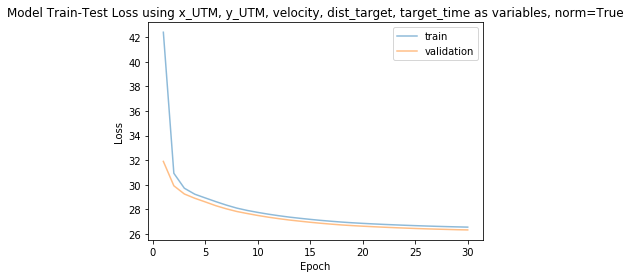

In [22]:
from scipy.stats import norm as norm_stat
from sklearn.metrics import mean_squared_error

# Train and test Loss
train_loss = lstm_model.train_loss
val_loss = lstm_model.test_loss
loss_fig = plt.figure()
loss_title = 'Model Train-Test Loss using ' + ', '.join(columns) + ' as variables'+", norm="+str(norm)
plt.plot(np.arange(1, len(train_loss) + 1), train_loss,label="train",alpha=0.5)
plt.plot(np.arange(1, len(val_loss) + 1), val_loss,label="validation",alpha=0.5)
plt.title(loss_title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#loss_fig.savefig("./results/MLP/"+loss_title+" norm="+str(norm)+".png", bbox_inches='tight')
plt.show()

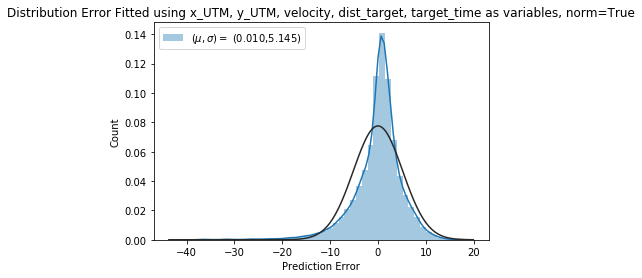

Error Distribution Norm Fitted parameters (mu,sigma): (0.009803273709182058, 5.1453891407624885)
MSE: 26.475125514051953


In [23]:
import seaborn as sns

# Metrics
MSE = mean_squared_error(y_pred_arr, y_test)
error = y_pred_arr - y_test

norm_fitted = norm_stat.fit(error)

# Distribution Error Histogram
hist_fig, ax = plt.subplots()
ax = sns.distplot(error,fit=norm_stat,label= r"$(\mu,\sigma)=$ (" + str('%.3f'%norm_fitted[0]) + "," + str('%.3f'%norm_fitted[1]) + ")"  )
hist_title = 'Distribution Error Fitted using ' + ', '.join(columns) + ' as variables'+", norm="+str(norm)
plt.title(hist_title)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.legend()
#hist_fig.savefig("./results/MLP/"+hist_title+" norm="+str(norm)+".png", bbox_inches='tight')
plt.show()


print("Error Distribution Norm Fitted parameters (mu,sigma):", norm_stat.fit(error))
print("MSE:", MSE)

In [24]:
error.shape

(159675, 1)